In [1]:
### import required libraries and pkgs ###
import glob
import os
import librosa
import numpy as np
#from sklearn.model_selection import KFold
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:

def Myextract_features(filePath, sampleRate=44100):
    factor = 0.4 #alpha
    
    signal,sr = librosa.load(filePath, sampleRate)
    signal = librosa.effects.time_stretch(signal,factor)
    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)

    features = np.concatenate((mel,mfcc,centroid),axis=0)
    #features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [3]:
import pandas as pd
import numpy as np
import librosa

filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/normal.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:2500]
all_Normalfiles = parent_dir +sub_dir+ filenames


all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/anomaly.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)

parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:1000]
all_Anomalyfiles = parent_dir +sub_dir+ filenames

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(8633, 149, 646)
(8633,)
(2308, 149, 646)
(2308,)
(10941, 149, 646)


In [4]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(7001, 149, 646)
(2189, 149, 646)
(1751, 149, 646)
(7001, 149, 646)
(2189, 149, 646)
(1751, 149, 646)


In [5]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 149, 200)     597600      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 149, 200)     387800      ['input_1[0][0]']                
                                                                                                  
 add (Add)                      (None, 149, 200)     0           ['bidirectional[0][0]',          
                                                                  'conv1d[0][0]']             

In [6]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)

Epoch 1/20
55/55 [==============================] - 29s 469ms/step - loss: 86.8680 - accuracy: 0.9054 - mean_squared_error: 0.4999 - val_loss: 17.3834 - val_accuracy: 0.9874 - val_mean_squared_error: 0.5000
Epoch 2/20
55/55 [==============================] - 26s 478ms/step - loss: 13.9660 - accuracy: 0.9800 - mean_squared_error: 0.5000 - val_loss: 14.5927 - val_accuracy: 0.9909 - val_mean_squared_error: 0.5000
Epoch 3/20
55/55 [==============================] - 24s 432ms/step - loss: 6.3608 - accuracy: 0.9904 - mean_squared_error: 0.5000 - val_loss: 11.8639 - val_accuracy: 0.9920 - val_mean_squared_error: 0.5000
Epoch 4/20
55/55 [==============================] - 24s 428ms/step - loss: 3.6636 - accuracy: 0.9920 - mean_squared_error: 0.5000 - val_loss: 11.9058 - val_accuracy: 0.9920 - val_mean_squared_error: 0.5000
Epoch 5/20
55/55 [==============================] - 24s 435ms/step - loss: 2.5073 - accuracy: 0.9939 - mean_squared_error: 0.5000 - val_loss: 10.4945 - val_accuracy: 0.9920 -

In [7]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.994518
Precision: 0.993593
Recall: 0.999414
F1 score: 0.996495
Cohens kappa: 0.983917
ROC AUC: 0.988296
[[ 471   11]
 [   1 1706]]


In [8]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[1476    0]
 [   0 5525]]


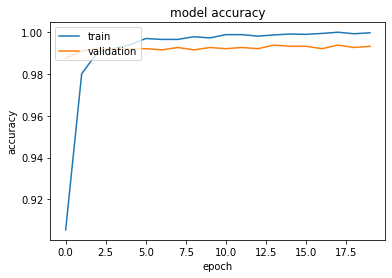

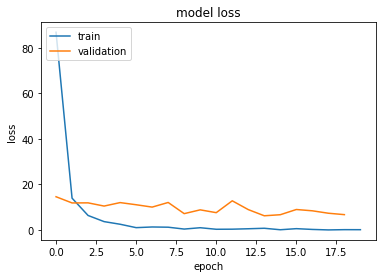

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 149, 200)    597600      ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 149, 200)     387800      ['input_2[0][0]']                
                                                                                                  
 add_1 (Add)                    (None, 149, 200)     0           ['bidirectional_1[0][0]',  

In [11]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)

Epoch 1/20
55/55 [==============================] - 26s 425ms/step - loss: 0.1594 - accuracy: 0.9349 - mean_squared_error: 0.4548 - val_loss: 0.1343 - val_accuracy: 0.9880 - val_mean_squared_error: 0.4989
Epoch 2/20
55/55 [==============================] - 22s 408ms/step - loss: 0.0270 - accuracy: 0.9951 - mean_squared_error: 0.4839 - val_loss: 0.0308 - val_accuracy: 0.9937 - val_mean_squared_error: 0.4993
Epoch 3/20
55/55 [==============================] - 24s 436ms/step - loss: 0.0149 - accuracy: 0.9971 - mean_squared_error: 0.4910 - val_loss: 0.0145 - val_accuracy: 0.9943 - val_mean_squared_error: 0.4982
Epoch 4/20
55/55 [==============================] - 24s 445ms/step - loss: 0.0095 - accuracy: 0.9984 - mean_squared_error: 0.4939 - val_loss: 0.0103 - val_accuracy: 0.9943 - val_mean_squared_error: 0.4972
Epoch 5/20
55/55 [==============================] - 27s 488ms/step - loss: 0.0071 - accuracy: 0.9987 - mean_squared_error: 0.4954 - val_loss: 0.0089 - val_accuracy: 0.9966 - val_me

In [12]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.995432
Precision: 0.998238
Recall: 0.995899
F1 score: 0.997067
Cohens kappa: 0.986737
ROC AUC: 0.994838
[[ 479    3]
 [   7 1700]]


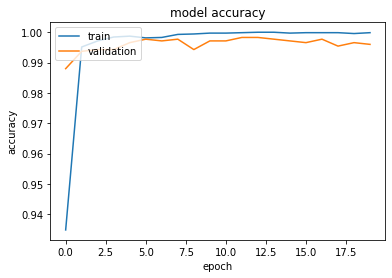

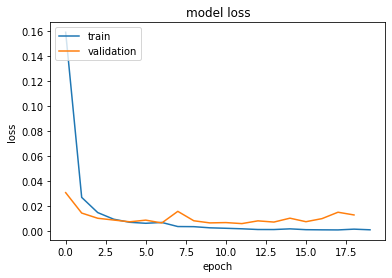

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[1476    0]
 [   0 5525]]


In [15]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 50, batch_size = 128, verbose = 1)

Epoch 1/50
55/55 [==============================] - 30s 479ms/step - loss: 0.0011 - accuracy: 0.9997 - mean_squared_error: 0.4994 - val_loss: 0.1388 - val_accuracy: 0.9703 - val_mean_squared_error: 0.4773
Epoch 2/50
55/55 [==============================] - 23s 413ms/step - loss: 0.0020 - accuracy: 0.9994 - mean_squared_error: 0.4990 - val_loss: 1.7076 - val_accuracy: 0.3541 - val_mean_squared_error: 0.4017
Epoch 3/50
55/55 [==============================] - 22s 409ms/step - loss: 0.0017 - accuracy: 0.9996 - mean_squared_error: 0.4992 - val_loss: 0.0414 - val_accuracy: 0.9914 - val_mean_squared_error: 0.4971
Epoch 4/50
55/55 [==============================] - 22s 408ms/step - loss: 0.0019 - accuracy: 0.9996 - mean_squared_error: 0.4991 - val_loss: 0.0309 - val_accuracy: 0.9920 - val_mean_squared_error: 0.4897
Epoch 5/50
55/55 [==============================] - 22s 407ms/step - loss: 5.4257e-04 - accuracy: 1.0000 - mean_squared_error: 0.4995 - val_loss: 0.0148 - val_accuracy: 0.9954 - va

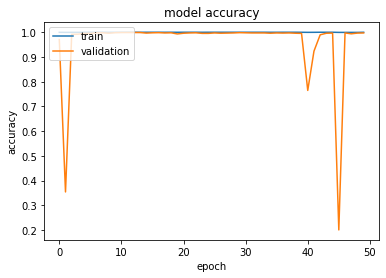

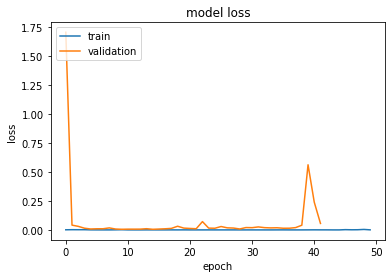

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.997259
Precision: 0.999413
Recall: 0.997071
F1 score: 0.998240
Cohens kappa: 0.992042
ROC AUC: 0.997498
[[ 481    1]
 [   5 1702]]


In [18]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.997259
Precision: 0.999413
Recall: 0.997071
F1 score: 0.998240
Cohens kappa: 0.992042
ROC AUC: 0.997498
[[ 481    1]
 [   5 1702]]


In [19]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[1476    0]
 [   0 5525]]


In [20]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model2 = Model(inputs, outputs)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 149, 200)    597600      ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 149, 200)     387800      ['input_3[0][0]']                
                                                                                                  
 add_2 (Add)                    (None, 149, 200)     0           ['bidirectional_2[0][0]',  

In [21]:
model2.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model2.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 50, batch_size = 128, verbose = 1)

Epoch 1/50
55/55 [==============================] - 25s 416ms/step - loss: 0.1544 - accuracy: 0.9480 - mean_squared_error: 0.4576 - val_loss: 0.3995 - val_accuracy: 0.9246 - val_mean_squared_error: 0.4719
Epoch 2/50
55/55 [==============================] - 22s 398ms/step - loss: 0.0325 - accuracy: 0.9924 - mean_squared_error: 0.4828 - val_loss: 0.0697 - val_accuracy: 0.9903 - val_mean_squared_error: 0.4994
Epoch 3/50
55/55 [==============================] - 23s 412ms/step - loss: 0.0150 - accuracy: 0.9960 - mean_squared_error: 0.4911 - val_loss: 0.0354 - val_accuracy: 0.9931 - val_mean_squared_error: 0.4994
Epoch 4/50
55/55 [==============================] - 24s 430ms/step - loss: 0.0076 - accuracy: 0.9986 - mean_squared_error: 0.4952 - val_loss: 0.0104 - val_accuracy: 0.9954 - val_mean_squared_error: 0.4989
Epoch 5/50
55/55 [==============================] - 23s 410ms/step - loss: 0.0072 - accuracy: 0.9981 - mean_squared_error: 0.4961 - val_loss: 0.0079 - val_accuracy: 0.9971 - val_me

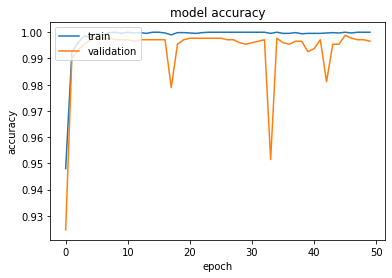

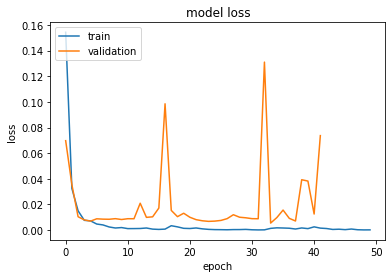

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
#test
pred = model2.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.997259
Precision: 0.997659
Recall: 0.998828
F1 score: 0.998244
Cohens kappa: 0.992007
ROC AUC: 0.995265
[[ 478    4]
 [   2 1705]]


In [24]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model3 = Model(inputs, outputs)
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 149, 200)    597600      ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 149, 200)     387800      ['input_4[0][0]']                
                                                                                                  
 add_3 (Add)                    (None, 149, 200)     0           ['bidirectional_3[0][0]',  

In [25]:
model3.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model3.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 30, batch_size = 128, verbose = 1)

Epoch 1/30
55/55 [==============================] - 28s 460ms/step - loss: 0.2200 - accuracy: 0.9189 - mean_squared_error: 0.4565 - val_loss: 0.1858 - val_accuracy: 0.9852 - val_mean_squared_error: 0.4987
Epoch 2/30
55/55 [==============================] - 22s 403ms/step - loss: 0.0258 - accuracy: 0.9939 - mean_squared_error: 0.4853 - val_loss: 0.0567 - val_accuracy: 0.9920 - val_mean_squared_error: 0.4997
Epoch 3/30
55/55 [==============================] - 22s 398ms/step - loss: 0.0137 - accuracy: 0.9967 - mean_squared_error: 0.4921 - val_loss: 0.0223 - val_accuracy: 0.9943 - val_mean_squared_error: 0.4991
Epoch 4/30
55/55 [==============================] - 22s 408ms/step - loss: 0.0110 - accuracy: 0.9973 - mean_squared_error: 0.4945 - val_loss: 0.0139 - val_accuracy: 0.9960 - val_mean_squared_error: 0.4989
Epoch 5/30
55/55 [==============================] - 22s 402ms/step - loss: 0.0061 - accuracy: 0.9986 - mean_squared_error: 0.4961 - val_loss: 0.0087 - val_accuracy: 0.9966 - val_me

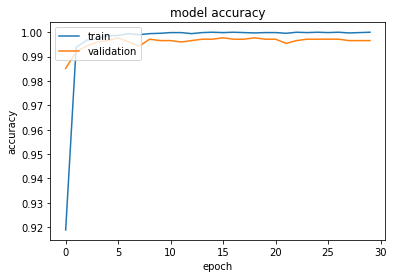

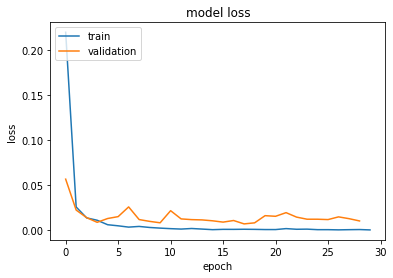

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
#test
pred = model3.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.997259
Precision: 0.997659
Recall: 0.998828
F1 score: 0.998244
Cohens kappa: 0.992007
ROC AUC: 0.995265
[[ 478    4]
 [   2 1705]]


In [29]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[1476    0]
 [   0 5525]]


In [30]:
# two sided model
#from keras.layers.core import Input, Model
#with dropout
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
#outputs = BatchNormalization()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 149, 200)    597600      ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 149, 200)     387800      ['input_5[0][0]']                
                                                                                                  
 add_4 (Add)                    (None, 149, 200)     0           ['bidirectional_4[0][0]',  

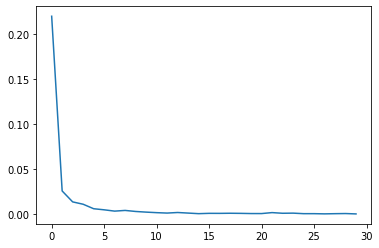

In [31]:
plt.plot(history.history['loss'])
plt.show()